# Traffic Sign Recognition: Evaluation & Scaling Analysis
Leo Barnes
## Sections
1. Model Evaluation
2. Performance Visualization
3. Scaling Analysis (1000x data)

## Introduction

This notebook is an evaluation of two neural network architectures, ResNet-18 and EfficientNet-B0, used on the German Traffic Sign Recognition Benchmark (GTRSB) data, followed by scaling analysis to assess the readiness if we had a data set 1000x the size.

The evaluation method we take is evaluating multiple different metrics. We do this as no single metric can capture all aspects of the model's performance in a setting where the performance determines how safe the product is.

The metrics we are assessing are:
1. Accuracy (top 1 and top 5)
2. Precision and Recall (per class and macro averaged)
3. F1 score (harmonic mean balancing both)
4. Confusion Matrix (analysing patterns in errors)
5. Throughput (feasibility of real time deployment)

For this setting we need multiple metrics in order to understand what works, what fails, our confidence, and whether this can actually run in real time. A model with 90% accuracy but a throughput of 1 FPS is useless for driving in real time. Similarly, a high accuracy with systematic failures on critical signs (eg stop, yield) is incredibly dangerous.


In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from scipy.stats import chi2_contingency

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cpu


In [2]:
import kagglehub #Load dataset

path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")
dataset_path = Path(path)

test_csv = pd.read_csv(dataset_path/"Test.csv")
train_csv = pd.read_csv(dataset_path/"Train.csv")

print(f"Train : {len(train_csv)},Test : {len(test_csv)},Classes : {train_csv['ClassId'].nunique()}")

Train : 39209,Test : 12630,Classes : 43


In [3]:
#Data set and data loader
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

class GTSRBDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(self.root_dir / row["Path"]).convert("RGB")
        label = row["ClassId"]
        if self.transform:
            img = self.transform(img)
        return img, label

test_dataset = GTSRBDataset(test_csv, root_dir=dataset_path, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

print(f"Test loader: {len(test_loader)} batches")

Test loader: 198 batches


## Mathematics of our Evaluation Metrics

Before we implement our evaluating function, we state the mathematical definitions of each metric and also give some justifications.

## Accuracy

Accuracy is our primary classification metric. It is the proportion of predictions that are correct over the total number of predictions.

$$\text{Accuracy} = \frac{\text{Correct Predictions}}{\text{Total Predictions}} = \frac{1}{N} \sum_{i=1}^{N} \mathbb{1}(y_i = \hat{y}_i)$$

where $y_i$ is the true label and $\hat{y}_i$ is the predicted label for sample $i$.

Accuracy is a standard benchmark metric, we use it as it is highly interpretable as well as it being appropriate for GTRSB's relatively balanced classes.

We also assess top 5 accuracy. This represents the proportion of samples where the true class appears in the top 5 predictions.

$$\text{Top 5 Accuracy} = \frac{1}{N} \sum_{i=1}^{N} \mathbb{1}(y_i \in \text{top 5}(\hat{\mathbf{p}}_i))$$

where $\hat{\mathbf{p}}_i$ is the predicted probability distribution over all classes, $y_i$ is the true label.

The gap between the top 1 and top 5 measures the calibration of the model. A large gap indicates that the model knows when it's uncertain, and spreads the probability over similar classes, and a small gap implies that when the model gives overconfident predictions that go wrong, are completely wrong. For safety applications like ours, awareness of uncertainty is really important. A model with a high top 5 accuracy could potentially use something like human verification when it's uncertain, making it safer than an overconfident model.

The baseline accuracy for random predictions in 43 classes for top 5 accuracy is 11.6% (5/43)

## Precision and Recall

The recision for a class $c$ is represented by:

$$\text{Precision}_c = \frac{TP_c}{TP_c + FP_c}$$

Of all predictions for class $c$, this measures the proportion of predictions that are correct.

The recall for a class $c$ is represented by:

$$\text{Recall}_c = \frac{TP_c}{TP_c + FN_c}$$

Of all actual instances of class $c$, the recall measures the proportion that we actually detected. $TP_c$ is the number of true positives in class $c$, $FN_c$ is number of false negatives in class $c$.

For our GTRSB setting, recall will matter more than precision. Missing a stop sign (with low recall) can cause accidents, when false alarms (with low precision) can be irritating but safe. To understand the whole picture, however, we need both.

## F1 Score

F1 score is represented by:

$$F_1 = \frac{2 \cdot \text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}} = \frac{2 \cdot TP}{2 \cdot TP + FP + FN}$$

F1 score is the harmonic mean, which is much better suited for our case where we want to penalise imbalances between metrics. Harmonic mean is more conservative than other methods, which makes it work very well in safety related applications.


In [4]:
# Evaluation function
def evaluate_model(model, test_loader, device, model_name):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    
    start_time = time.time()
    total_images = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            probs = torch.softmax(outputs,dim=1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            total_images += images.size(0)
    
    inference_time = time.time() - start_time
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs_arr = np.array(all_probs)
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, support = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)
    per_class_precision, per_class_recall, per_class_f1, per_class_support = \
        precision_recall_fscore_support(all_labels, all_preds, average=None, zero_division=0)
    
    top5_preds = np.argsort(all_probs_arr, axis=1)[:, -5:]
    top5_accuracy = np.mean([label in top5_preds[i] for i, label in enumerate(all_labels)])
    cm = confusion_matrix(all_labels, all_preds)
    throughput = total_images / inference_time
    
    print(f"\n{model_name}")
    print(f"  Accuracy: {accuracy:.4f} | Top-5: {top5_accuracy:.4f} | F1: {f1:.4f}")
    print(f"  Inference: {inference_time:.2f}s | Throughput: {throughput:.2f} img/s")
    
    return {
        'accuracy': accuracy, 'top5_accuracy': top5_accuracy, 'precision': precision,
        'recall': recall, 'f1': f1, 'per_class_precision': per_class_precision,
        'per_class_recall': per_class_recall, 'per_class_f1': per_class_f1,
        'per_class_support': per_class_support, 'confusion_matrix': cm,
        'predictions': all_preds, 'labels': all_labels, 'probabilities': all_probs_arr,
        'inference_time': inference_time, 'throughput': throughput, 'total_images': total_images
    }

In [5]:
# ResNet
os.makedirs('results', exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#ResNet
resnet_model = models.resnet18(weights=None)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 43)
resnet_model.load_state_dict(torch.load('/Users/ad/Desktop/data science/resnet18_traffic_signs.pth', map_location=device))
resnet_model.to(device).eval()

resnet_results = evaluate_model(resnet_model, test_loader, device, "ResNet-18")

# Clear GPU memory
del resnet_model
torch.cuda.empty_cache() if torch.cuda.is_available() else None


ResNet-18
  Accuracy: 0.6836 | Top-5: 0.9356 | F1: 0.6884
  Inference: 248.77s | Throughput: 50.77 img/s


In [6]:
# EfficientNet
from torchvision.models import efficientnet_b0

base_model = efficientnet_b0(weights=None) #Different architecture, so need to rewrite
base_model.classifier = nn.Identity()  # Remove classifier

efficientnet_model = nn.Sequential(base_model,
    nn.Linear(1280, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 43),
)

# Load saved weights
efficientnet_model.load_state_dict(torch.load('/Users/ad/Desktop/data science/efficientnet_best.pth', map_location=device))
efficientnet_model.to(device).eval()

efficientnet_results = evaluate_model(efficientnet_model, test_loader, device, "EfficientNet-B0")

del efficientnet_model
torch.cuda.empty_cache() if torch.cuda.is_available() else None


EfficientNet-B0
  Accuracy: 0.7415 | Top-5: 0.9475 | F1: 0.7391
  Inference: 740.16s | Throughput: 17.06 img/s


Looking at the results for our chosen metrics, we see EfficientNet achieves higher scores than ResNet in almost every way, and hence appears to be the better model choice, though they don't seem overly far away from each other. They both have good sized gaps between top 1 and top 5 accuracy implying they both have decent calibration. Whilst ResNet does process images much faster with a better throughput, EfficientNet's architecture gives us a more reliable performance in classification.

## Hypothesis Testing

Our evaluation shows us that EfficientNet achieves a higher accuracy on our test set. In order to verify this and check that the difference in accuracy is real, we perform a chi squared test

We use Pearson's Chi Squared Test for independence, which tests whether two categorical variables (model type, correct/incorrect) are independent from one another. Chi squared tests are appropriate for large samples, and they do not require any assumptions about the underlying distributions.

In [7]:
# Accuracy Chi Squared test
resnet_correct = (resnet_results['predictions'] == resnet_results['labels'])
efficientnet_correct = (efficientnet_results['predictions'] == efficientnet_results['labels'])
n_total = len(resnet_results['labels'])

contingency_table = np.array([
    [np.sum(resnet_correct), np.sum(~resnet_correct)],
    [np.sum(efficientnet_correct), np.sum(~efficientnet_correct)]
])

print("                  Correct    Incorrect")
print(f"ResNet-18:        {contingency_table[0, 0]:<10} {contingency_table[0, 1]}")
print(f"EfficientNet-B0:  {contingency_table[1, 0]:<10} {contingency_table[1, 1]}")

chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-squared statistic: {chi2:.2f}")
print(f"p value: {p_value:.2e}")
print(f"Degrees of freedom: {dof}")

n = len(resnet_correct) # confidence interval
resnet_acc = np.mean(resnet_correct)
efficientnet_acc = np.mean(efficientnet_correct)
resnet_se = np.sqrt(resnet_acc * (1 - resnet_acc)/n) #standard error
efficientnet_se = np.sqrt(efficientnet_acc * (1 - efficientnet_acc)/n)

# 95% CI, accuracy plus or minus 1.96 * SE
z_score = 1.96
resnet_ci = (resnet_acc - z_score * resnet_se, resnet_acc + z_score * resnet_se)
efficientnet_ci = (efficientnet_acc - z_score * efficientnet_se,
                    efficientnet_acc + z_score * efficientnet_se)

print(f"\n95% Confidence Intervals:")
print(f"ResNet-18:       {resnet_acc:.1%} +- {z_score*resnet_se:.1%}")
print(f"                 [{resnet_ci[0]:.1%}, {resnet_ci[1]:.1%}]")
print(f"EfficientNet-B0: {efficientnet_acc:.1%} +- {z_score*efficientnet_se:.1%}")
print(f"                 [{efficientnet_ci[0]:.1%}, {efficientnet_ci[1]:.1%}]")


                  Correct    Incorrect
ResNet-18:        8634       3996
EfficientNet-B0:  9365       3265

Chi-squared statistic: 103.00
p value: 3.35e-24
Degrees of freedom: 1

95% Confidence Intervals:
ResNet-18:       68.4% +- 0.8%
                 [67.5%, 69.2%]
EfficientNet-B0: 74.1% +- 0.8%
                 [73.4%, 74.9%]


We can see that the difference in accuracy is very signifcant with an incredibly low p value of $3.35e^{-24}$. We can also see no overlap in the respective confidence intervals which shows this difference is real. This is something that could be pretty clear as the sample size is very large (roughly 13,000 images) meaning the standard error would be very small. For our test set of approximately 13,000 images, the difference in accuracy of 5.7% represents approximately 741 additional correct predictions.

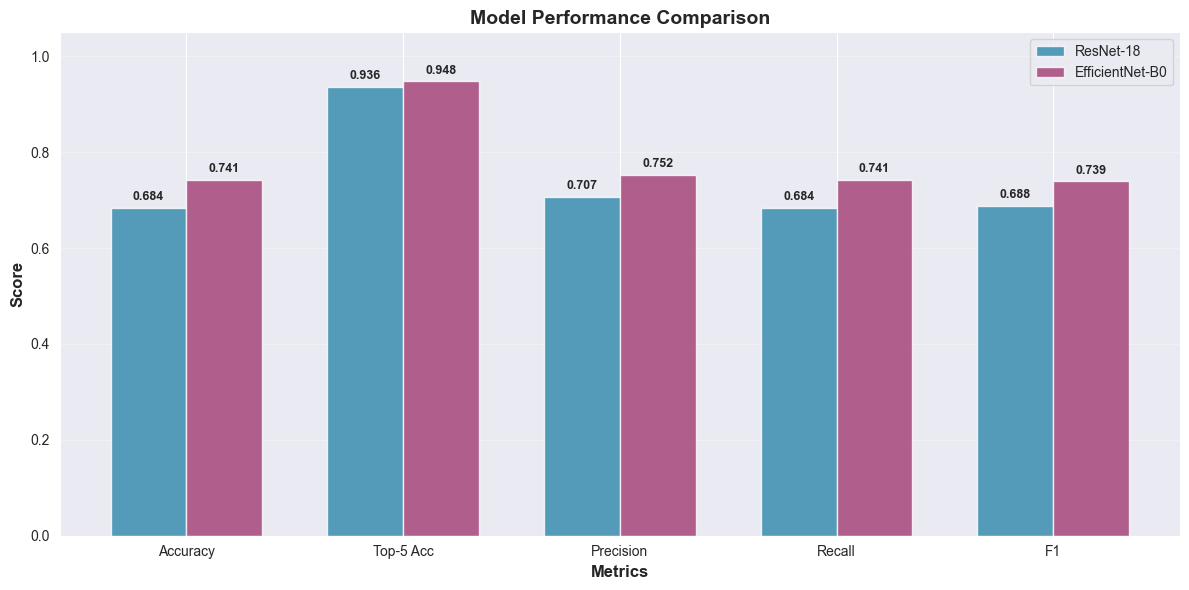

In [8]:
metrics = ['accuracy', 'top5_accuracy', 'precision', 'recall', 'f1'] #metrics we test
metric_labels = ['Accuracy', 'Top-5 Acc', 'Precision', 'Recall', 'F1']
resnet_scores = [resnet_results[m] for m in metrics]
efficientnet_scores = [efficientnet_results[m] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, resnet_scores, width, label='ResNet-18', alpha=0.8, color='#2E86AB')
bars2 = ax.bar(x + width/2, efficientnet_scores, width, label='EfficientNet-B0', alpha=0.8, color='#A23B72')

ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metric_labels)
ax.legend()
ax.set_ylim([0, 1.05])
ax.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
               f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('results/01_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Confusion Matrices

We now look at confusion matrices. These are used for error analysis like analysing error patterns. This can answer questions like what types of signs are confused with other signs. This is needed to understand the systematic failures like in EfficientNet, as well as can guide and target improvements.

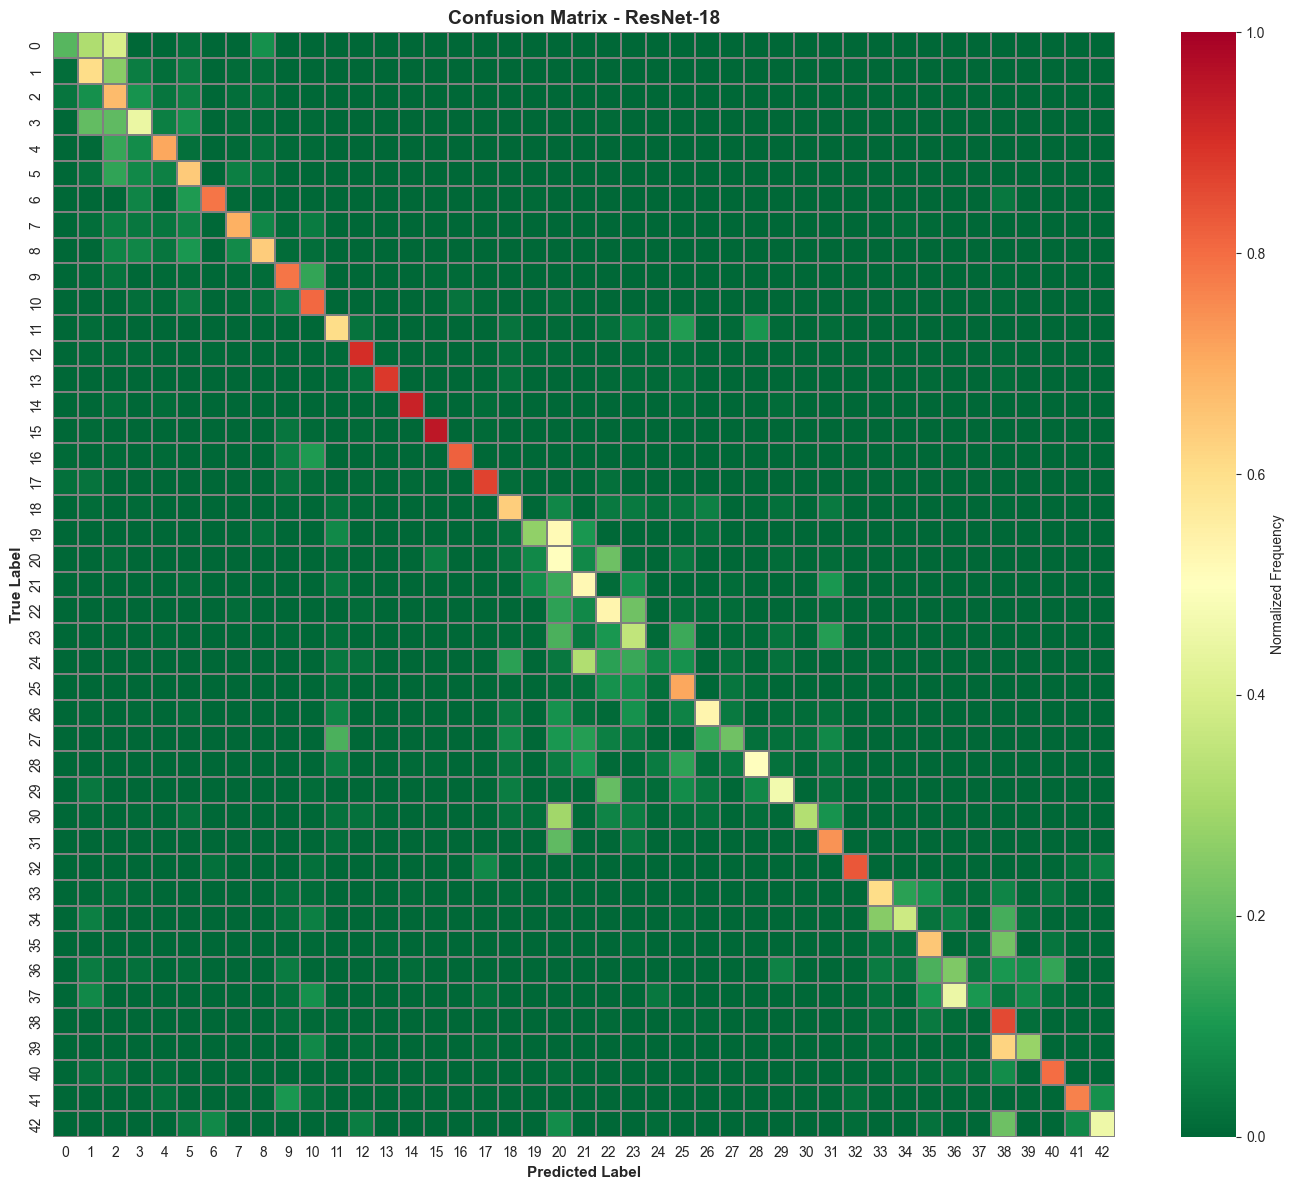


ResNet-18 - Top 10 Most Confused Pairs:
True   Pred   Rate       Count
39     38       62.2%      56
19     20       51.7%      31
37     36       45.0%      27
0      2        40.0%      24
24     21       32.2%      29
0      1        31.7%      19
30     20       29.3%      44
1      2        25.6%     184
34     33       25.0%      30
35     38       22.1%      86


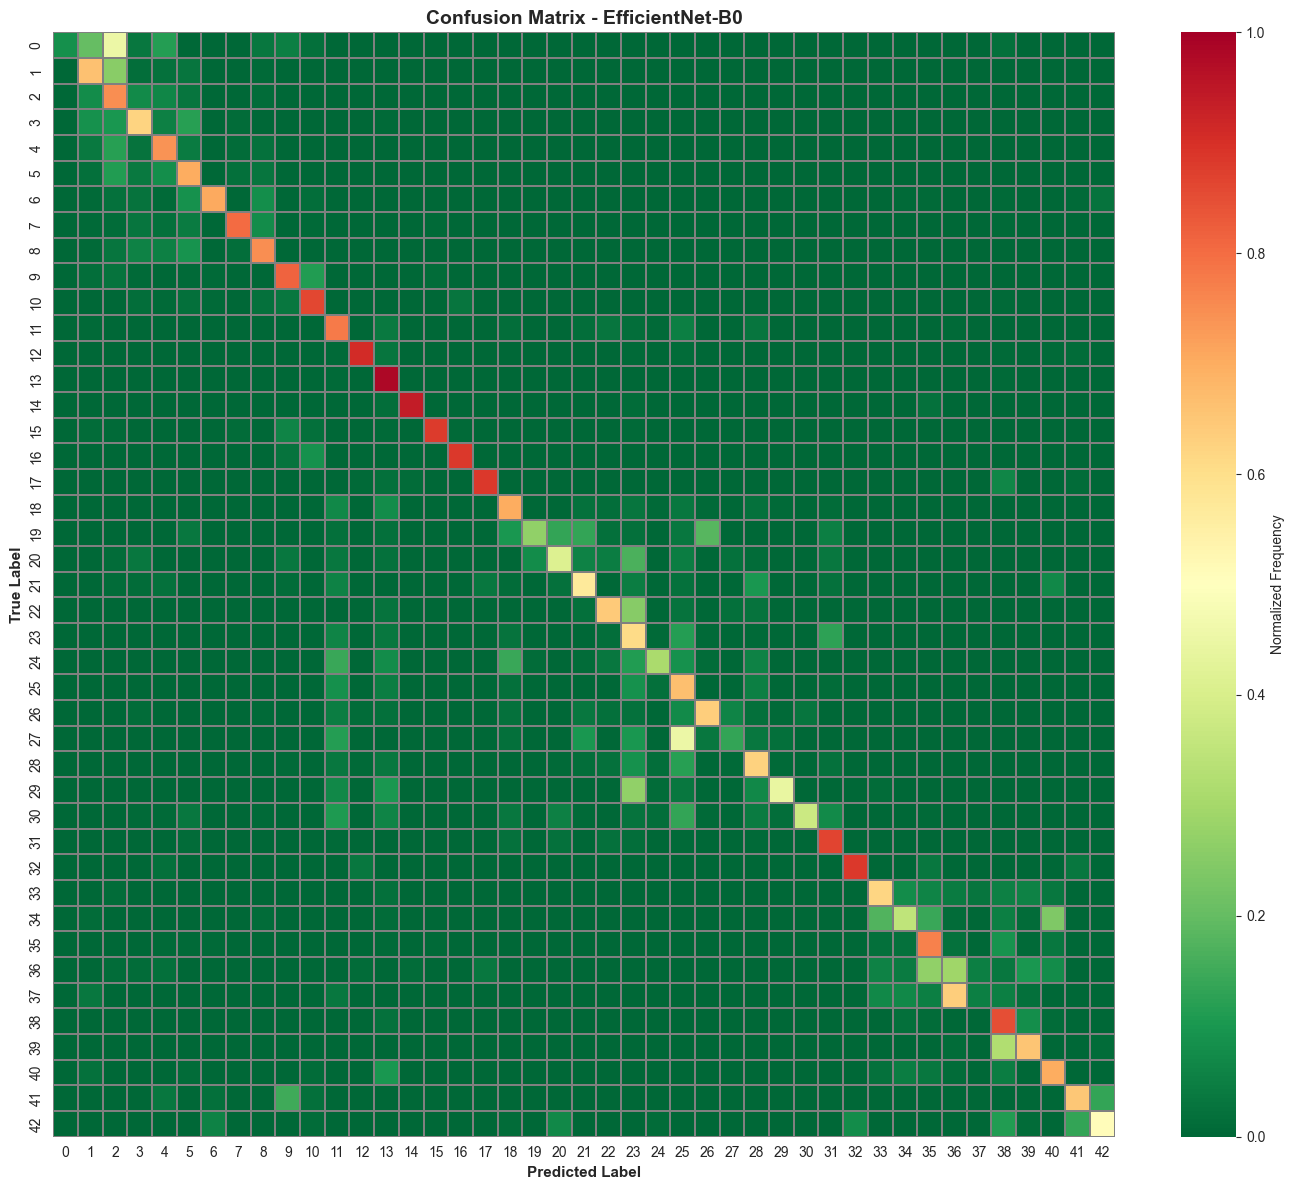


EfficientNet-B0 - Top 10 Most Confused Pairs:
True   Pred   Rate       Count
37     36       63.3%      38
0      2        45.0%      27
27     25       45.0%      27
39     38       32.2%      29
29     23       26.7%      24
36     35       26.7%      32
1      2        25.4%     183
22     23       25.0%      30
34     40       24.2%      29
0      1        20.0%      12


In [9]:
def plot_confusion_matrix(cm, model_name): #confusion matrices
    plt.figure(figsize=(14,12))
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=False, fmt='.2f', cmap='RdYlGn_r', vmin=0, vmax=1,
                cbar_kws={'label': 'Normalized Frequency'}, linewidths=0.1, linecolor='gray')
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=11, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=11, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'results/02_confusion_{model_name.lower().replace(" ", "_").replace("-", "")}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    # Most confused pairs
    confusion_pairs = [(i, j, cm_normalized[i, j], cm[i, j]) 
                       for i in range(cm.shape[0]) for j in range(cm.shape[0]) 
                       if i != j and cm_normalized[i, j] > 0.05]
    confusion_pairs.sort(key=lambda x: x[2], reverse=True)
    
    print(f"\n{model_name} - Top 10 Most Confused Pairs:")
    print(f"{'True':<6} {'Pred':<6} {'Rate':<10} {'Count'}")
    for true_c, pred_c, rate, count in confusion_pairs[:10]:
        print(f"{true_c:<6} {pred_c:<6} {rate:>7.1%}    {int(count):>4}")

plot_confusion_matrix(resnet_results['confusion_matrix'], "ResNet-18")
plot_confusion_matrix(efficientnet_results['confusion_matrix'], "EfficientNet-B0")

The most confused pairs tell us what particular traffic signs are being misclassified as others. Both models show similar confusion patterns, which suggests that these errors come from visual similarities in the signs rather than a unique weakness in the model architecture.

Something quite worrying that I noticed is that both ResNet and EfficientNet have confusion on class 0, confusing it most commonly with class 2. Class 0 represents a speed limit sign of 20, and class 2 represents a speed limit sign of 50, which would obviously be very dangerous if these models were to actually be implemented into a self driving car.

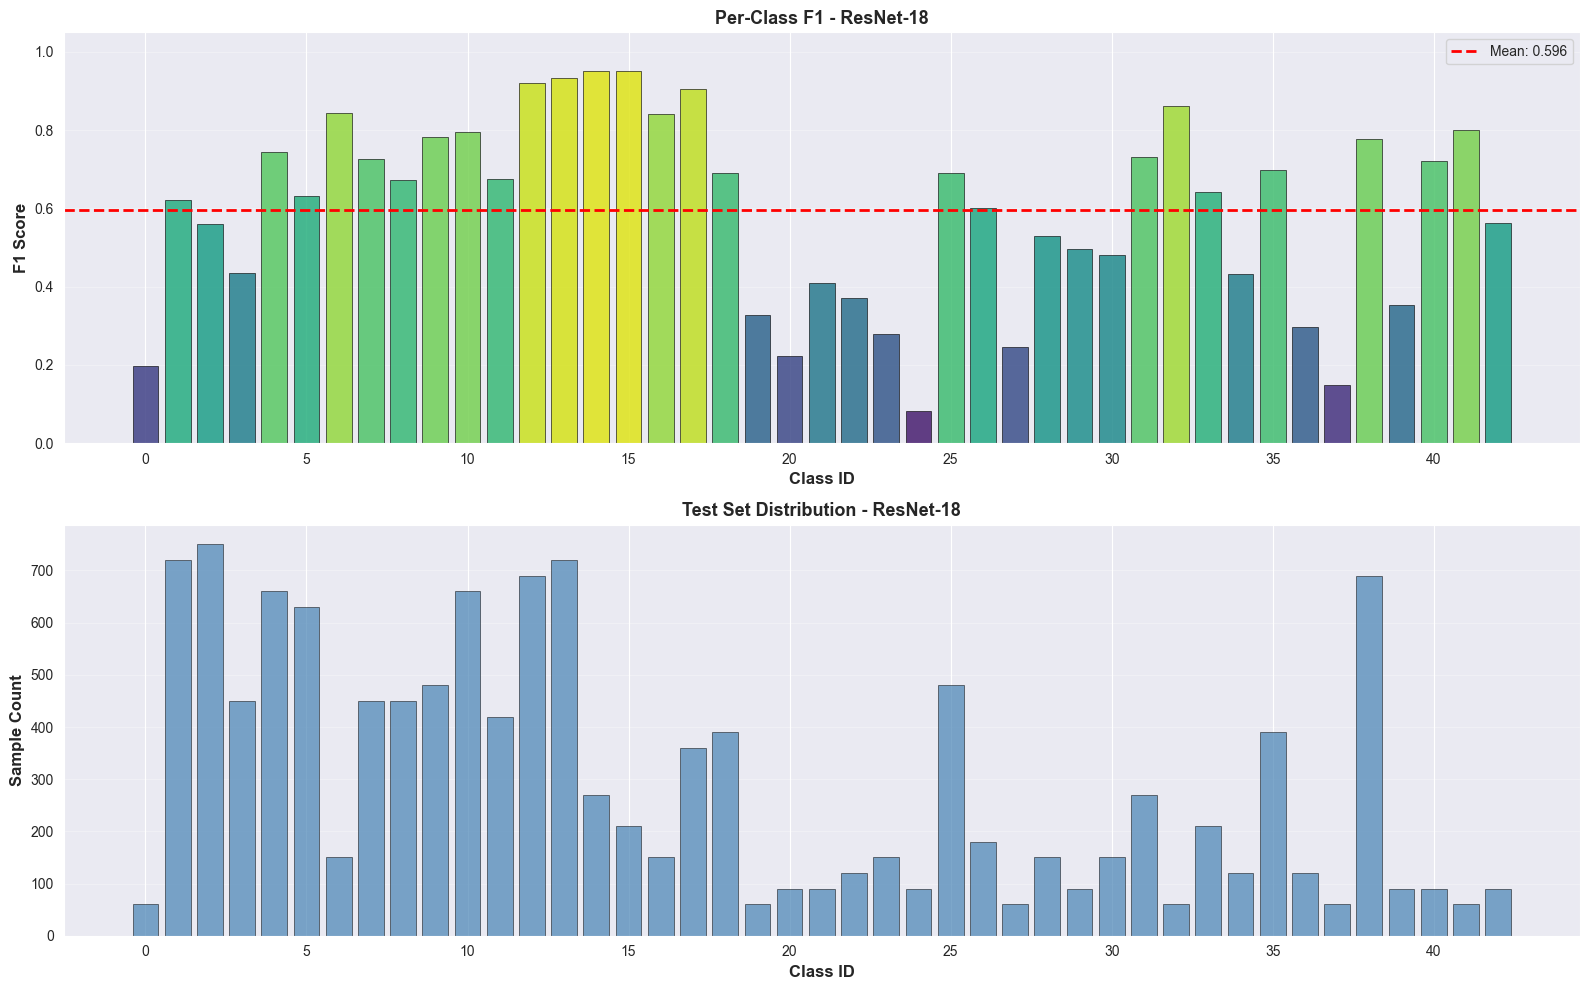


ResNet-18 - Worst 5 Classes:
  Class 24: F1=0.083, Precision=0.111, Recall=0.067
  Class 37: F1=0.148, Precision=0.286, Recall=0.100
  Class 0: F1=0.198, Precision=0.216, Recall=0.183
  Class 20: F1=0.223, Precision=0.143, Recall=0.500
  Class 27: F1=0.245, Precision=0.283, Recall=0.217

ResNet-18 - Best 5 Classes:
  Class 15: F1=0.952, Precision=0.952, Recall=0.952
  Class 14: F1=0.951, Precision=0.973, Recall=0.930
  Class 13: F1=0.934, Precision=0.989, Recall=0.885
  Class 12: F1=0.920, Precision=0.937, Recall=0.903
  Class 17: F1=0.906, Precision=0.946, Recall=0.869


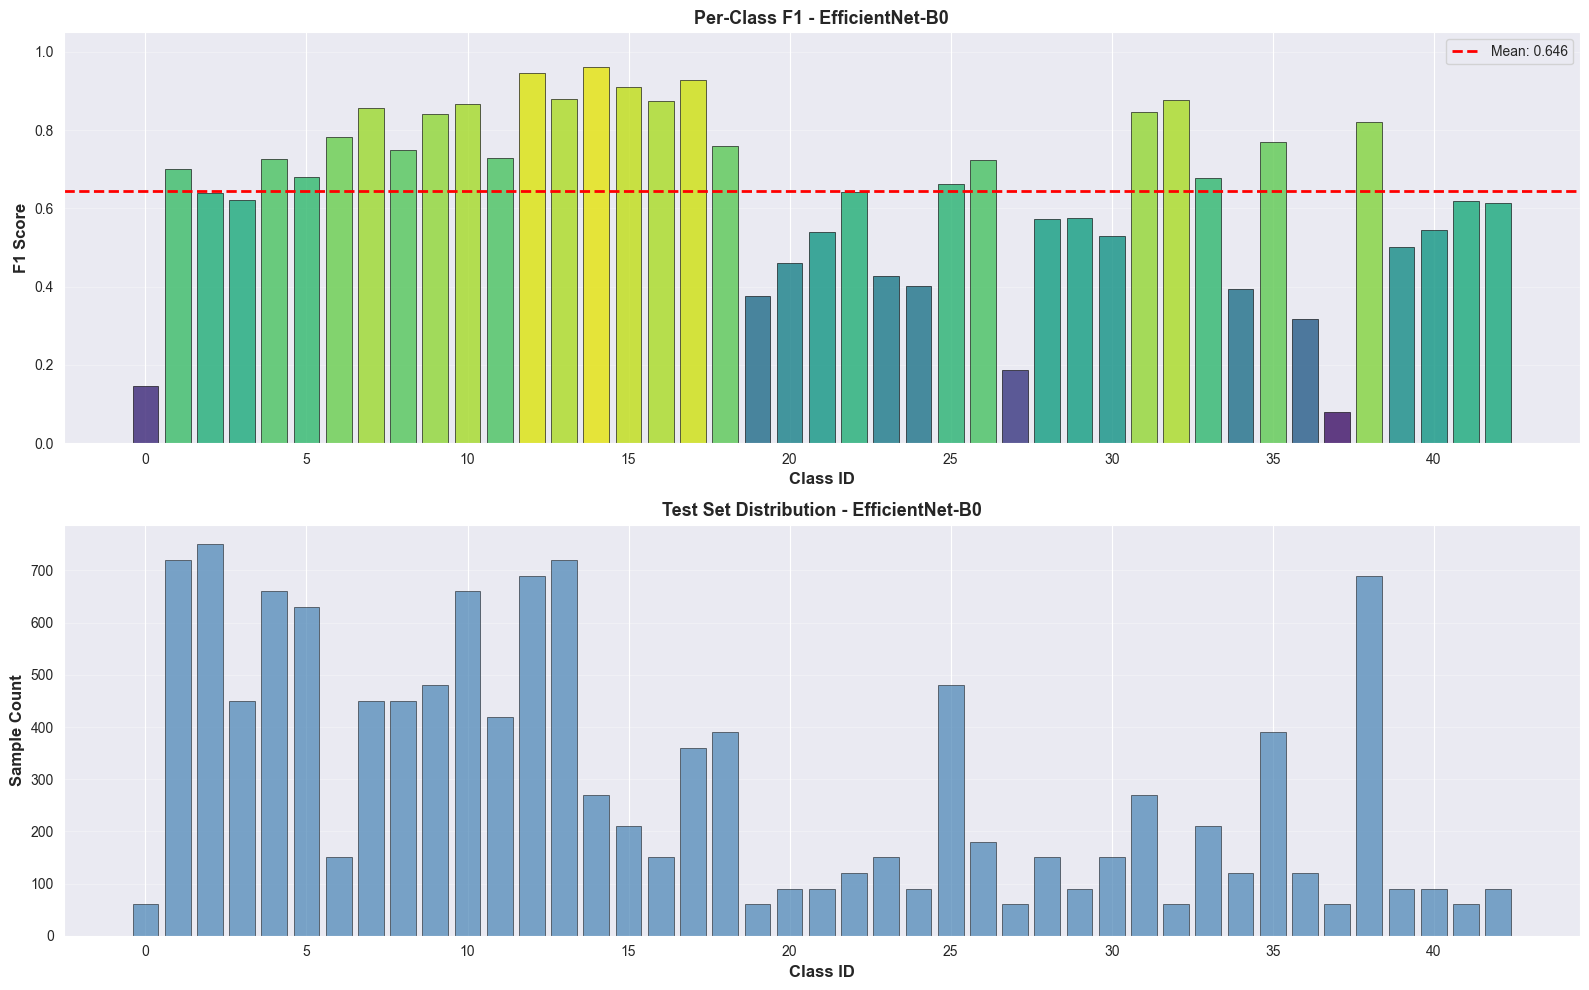


EfficientNet-B0 - Worst 5 Classes:
  Class 37: F1=0.080, Precision=0.200, Recall=0.050
  Class 0: F1=0.147, Precision=0.625, Recall=0.083
  Class 27: F1=0.188, Precision=0.320, Recall=0.133
  Class 36: F1=0.318, Precision=0.350, Recall=0.292
  Class 19: F1=0.376, Precision=0.640, Recall=0.267

EfficientNet-B0 - Best 5 Classes:
  Class 14: F1=0.960, Precision=0.981, Recall=0.941
  Class 12: F1=0.946, Precision=0.986, Recall=0.910
  Class 17: F1=0.927, Precision=0.973, Recall=0.886
  Class 15: F1=0.909, Precision=0.939, Recall=0.881
  Class 13: F1=0.880, Precision=0.796, Recall=0.983


In [10]:
def plot_per_class(results, model_name): # Performance per class
    n_classes = len(results['per_class_f1'])
    classes = range(n_classes)
    
    fig,(ax1, ax2) = plt.subplots(2,1,figsize=(16, 10))
    
    colors = plt.cm.viridis(results['per_class_f1'])
    ax1.bar(classes, results['per_class_f1'], color=colors, alpha=0.85, edgecolor='black', linewidth=0.5)
    ax1.set_xlabel('Class ID',fontsize=12,fontweight='bold')
    ax1.set_ylabel('F1 Score',fontsize=12,fontweight='bold')
    ax1.set_title(f'Per-Class F1 - {model_name}', fontsize=13, fontweight='bold')
    ax1.set_ylim([0, 1.05])
    ax1.axhline(y=results['per_class_f1'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {results["per_class_f1"].mean():.3f}')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    ax1.set_xticks(range(0, n_classes, 5))
    
    ax2.bar(classes, results['per_class_support'], color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
    ax2.set_xlabel('Class ID', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Sample Count', fontsize=12, fontweight='bold')
    ax2.set_title(f'Test Set Distribution - {model_name}', fontsize=13, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    ax2.set_xticks(range(0, n_classes, 5))
    
    plt.tight_layout()
    plt.savefig(f'results/03_perclass_{model_name.lower().replace(" ", "_").replace("-", "")}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    sorted_indices = np.argsort(results['per_class_f1'])
    print(f"\n{model_name} - Worst 5 Classes:")
    for idx in sorted_indices[:5]:
        print(f"  Class {idx}: F1={results['per_class_f1'][idx]:.3f}, "
              f"Precision={results['per_class_precision'][idx]:.3f}, "
              f"Recall={results['per_class_recall'][idx]:.3f}")
    
    print(f"\n{model_name} - Best 5 Classes:")
    for idx in sorted_indices[-5:][::-1]:
        print(f"  Class {idx}: F1={results['per_class_f1'][idx]:.3f}, "
              f"Precision={results['per_class_precision'][idx]:.3f}, "
              f"Recall={results['per_class_recall'][idx]:.3f}")

plot_per_class(resnet_results, "ResNet-18")
plot_per_class(efficientnet_results, "EfficientNet-B0")

These per class plots can tell us how both models handle the 43 classes of traffic signs. EfficientNet shows consistent performance across all the classes. ResNet's lowest F1 score is 0.083, although this is a poor performance, it shows that there are some true positives meaning it can occasionally detect the sign, even for its weakest class. EfficientNet has a lowest score of 0.080 for 24, which shows the same as above. Both of these scores could potentially be improved with targeted training data augmentation.

Both signs correctly classify many critical signs, like stop, yield and no entry, but again struggle with some of the speedlimit signs, in particular the 20 speed limit. This is understandable though given they are visually similar in lower resolutions.

### Throughput and Inference Time Analysis

Now we do some throughput comparison and inference time plots. Speed in this setting matters as if these models were deployed in a vehicle, the models must process frames in real time. The industry baseline online needs more than 30 FPS processing in order to make sure reactions are timely.

Look at the case where a car is moving at say 100 km/h (equal to ~28 m/s). This translates to 0.93 m per frame for 30 FPS, and 1.40 m at 20 FPS, meaning the difference of only 10 FPS could translate to almost 0.5 m of unmonitored travel.

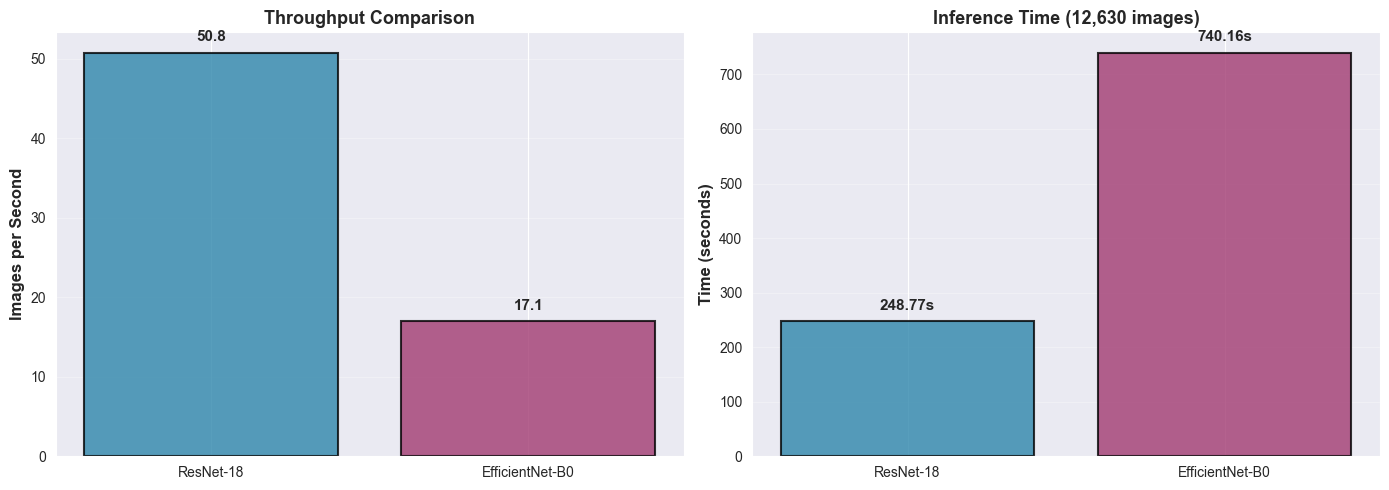

In [11]:
# Throughput comparison
models = ['ResNet-18', 'EfficientNet-B0']
throughputs = [resnet_results['throughput'], efficientnet_results['throughput']]
inference_times = [resnet_results['inference_time'], efficientnet_results['inference_time']]

fig,(ax1, ax2) = plt.subplots(1,2,figsize=(14,5))

bars1 = ax1.bar(models, throughputs, color=['#2E86AB', '#A23B72'], alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Images per Second', fontsize=12, fontweight='bold')
ax1.set_title('Throughput Comparison', fontsize=13, fontweight='bold')
ax1.grid(axis='y',alpha=0.3)
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + max(throughputs)*0.02,
            f'{height:.1f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

bars2 = ax2.bar(models, inference_times, color=['#2E86AB', '#A23B72'], alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Time (seconds)', fontsize=12, fontweight='bold')
ax2.set_title('Inference Time (12,630 images)', fontsize=13, fontweight='bold')
ax2.grid(axis='y',alpha=0.3)
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + max(inference_times)*0.02,
            f'{height:.2f}s', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('results/04_throughput.png', dpi=300, bbox_inches='tight')
plt.show()

We can see that ResNet achieves a significantly higher throughput and hence a much lower inference time. This can be explained from the underlying architecture of each model:

- EfficientNet uses depthwise separable convolutions as opposed to ResNet using the standard 3x3 convolutions,
- EfficientNet makes many small operations with irregular memory access when ResNet does larger and more regular operations
- ResNet also has better GPU parallelisation.

Especially for CPUs, ResNet's simpler architecture just executes faster.

What this means for deployment however, is that the choice of model depends on the application. ResNet beats the 30 FPS baseline by doubling it which would make it suitable for situations where latency is critical, but EfficientNet on the other hand would simply be too slow. The 23 FPS being below our benchmark of 30 FPS means it can still operate in some ranges where we the extra accuracy can make up for its throughput.


ResNet-18
  Errors: 3996/12630 (31.64%)
  Mean confidence on errors: 0.5256
  Mean confidence on correct: 0.7924


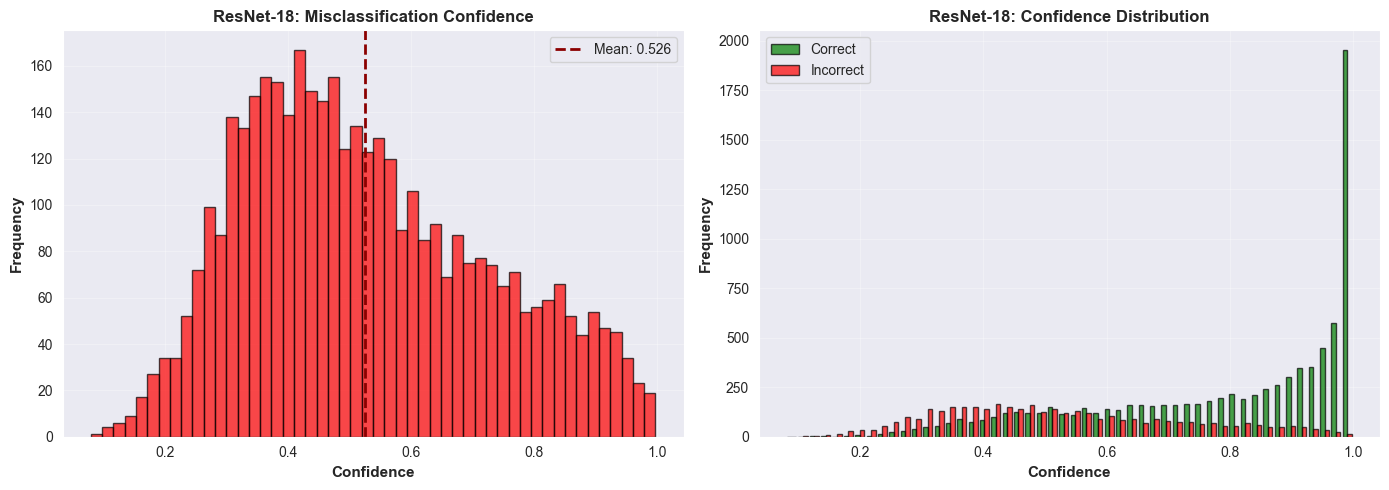


EfficientNet-B0
  Errors: 3265/12630 (25.85%)
  Mean confidence on errors: 0.6030
  Mean confidence on correct: 0.8874


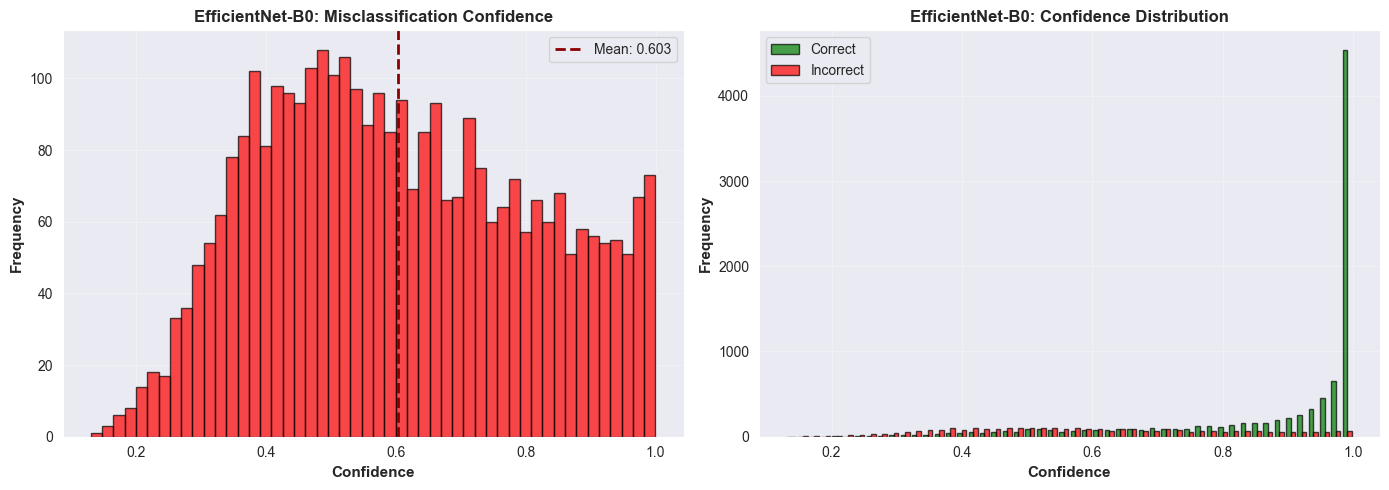

In [12]:
# Error analysis
def analyse_errors(results, model_name):
    predictions = np.array(results['predictions'])
    labels = np.array(results['labels'])
    probabilities = results['probabilities']
    
    errors = predictions != labels
    error_indices = np.where(errors)[0]
    correct_indices = np.where(~errors)[0]
    
    error_confidences = [probabilities[i][predictions[i]] for i in error_indices]
    correct_confidences = [probabilities[i][predictions[i]] for i in correct_indices]
    
    print(f"\n{model_name}")
    print(f"  Errors: {len(error_indices)}/{len(labels)} ({100*len(error_indices)/len(labels):.2f}%)")
    print(f"  Mean confidence on errors: {np.mean(error_confidences):.4f}")
    print(f"  Mean confidence on correct: {np.mean(correct_confidences):.4f}")
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].hist(error_confidences, bins=50, alpha=0.7, color='red', edgecolor='black')
    axes[0].set_xlabel('Confidence', fontsize=11, fontweight='bold')
    axes[0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
    axes[0].set_title(f'{model_name}: Misclassification Confidence', fontsize=12, fontweight='bold')
    axes[0].axvline(np.mean(error_confidences), color='darkred', linestyle='--', linewidth=2,
                   label=f'Mean: {np.mean(error_confidences):.3f}')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    axes[1].hist([correct_confidences, error_confidences], bins=50, 
                label=['Correct', 'Incorrect'], alpha=0.7, color=['green', 'red'], edgecolor='black')
    axes[1].set_xlabel('Confidence', fontsize=11, fontweight='bold')
    axes[1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
    axes[1].set_title(f'{model_name}: Confidence Distribution', fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'results/05_error_{model_name.lower().replace(" ", "_").replace("-", "")}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

analyse_errors(resnet_results, "ResNet-18")
analyse_errors(efficientnet_results, "EfficientNet-B0")

The above plots give some context on the confidence distributions of misclassifications, in other words, how certain a model is when making errors. Both ResNet and EfficientNet show that they know when they are guessing (mean of 0.53 and 0.60 respectively). The shapes of the graph are typically what we would expect, where the peaks (showing confidence where most misclassifications happen) are where they have lower confidence. The gaps between mean confidence on correct and mean confidence on errors show decent calibration for both models, and has some awareness that it is less confident when wrong and more confident when right.

## Scaling Analysis

Currently, our dataset has 39,209 images, takes up roughly 2 GB of storage and when run on CPU (Neva's or Gracie's laptop) has a run time of more than 2 hours, and roughly 5 minutes each when run on a GPU. If we were to scale this up to 1000x scale, we would have 39,209,000 images, roughly 2 TB of storage, and training time that we will calculate.

We are going to look at the effects of scaling on inference time and training time, including how feasible it is training on 1000x more data, as well as what infrastructure would be required to do so.

### Inference vs Training Scaling

**Inference** scales almost linearly as the images are processed independently. At our current throughput, processing 39 million images will require approximately 175 hours for ResNet or 641 hours for EfficientNet on a single GPU. With 32 GPUs at 90% efficiency, this reduces to 5.4 and 19.8 hours respectively.

**Training** faces fundamental bottlenecks due to gradient synchronisation. Training with a single GPU would need roughly 167 days for ResNet or 451 days for EfficientNet on 8 epochs. Distributed training will improve this but communication overhead will limit efficiency.

### Parallel Scaling and Amdahl's Law

Training neural networks at scale requires understanding the limits of parallelisation. Amdahl's Law quantifies the maximum speedup that can be achieved.

$$\text{Speedup}(N) = \frac{1}{s + \frac{p}{N}}$$

where N = number of GPUs, s = serial fraction, p = parallel fraction, and s + p = 1.

Based on an empirical study from Goyal et al. (2017), parallel efficiency decreases from 80% with 4 GPUs, to 65% 32 GPUs. With 32 GPUs, training times reduce to roughly 8 days for ResNet or 22 days with EfficientNet, which is computationally feasible for production scenarios.

In [13]:
def project_scaling(results, model_name, current_size=39209, scale_factor=1000):
    scaled_size = current_size * scale_factor
    time_per_image = results['inference_time'] / results['total_images']
    projected_time_hours = (scaled_size * time_per_image) / 3600

    print(f"\n{model_name} - 1000x Scaling")
    print(f"  Current: {current_size:,} images")
    print(f"  Scaled: {scaled_size:,} images")
    print(f"  Single GPU: {projected_time_hours:.2f} hours ({projected_time_hours/24:.2f} days)")
    print(f"\n  Multi-GPU (90% efficiency):")
    for n_gpus in [4, 8, 16, 32]:
        parallel_hours = projected_time_hours / (n_gpus * 0.90)
        print(f"    {n_gpus} GPUs: {parallel_hours:.2f} hours ({parallel_hours/24:.2f} days)")

    storage_tb = (scaled_size * 0.05 / 1024) / 1024
    print(f"\n  Storage: ~{storage_tb:.1f} TB")

    return {'scaled_size': scaled_size, 'projected_time_hours': projected_time_hours,
            'time_per_image': time_per_image, 'storage_tb': storage_tb}

resnet_scaling = project_scaling(resnet_results, "ResNet-18", len(train_csv))
efficientnet_scaling = project_scaling(efficientnet_results, "EfficientNet-B0", len(train_csv))



ResNet-18 - 1000x Scaling
  Current: 39,209 images
  Scaled: 39,209,000 images
  Single GPU: 214.52 hours (8.94 days)

  Multi-GPU (90% efficiency):
    4 GPUs: 59.59 hours (2.48 days)
    8 GPUs: 29.79 hours (1.24 days)
    16 GPUs: 14.90 hours (0.62 days)
    32 GPUs: 7.45 hours (0.31 days)

  Storage: ~1.9 TB

EfficientNet-B0 - 1000x Scaling
  Current: 39,209 images
  Scaled: 39,209,000 images
  Single GPU: 638.28 hours (26.59 days)

  Multi-GPU (90% efficiency):
    4 GPUs: 177.30 hours (7.39 days)
    8 GPUs: 88.65 hours (3.69 days)
    16 GPUs: 44.32 hours (1.85 days)
    32 GPUs: 22.16 hours (0.92 days)

  Storage: ~1.9 TB


### Inference Scaling


ResNet-18 - 1000x Scaling
  Current: 39,209 images
  Scaled: 39,209,000 images
  Single GPU: 214.52 hours (8.94 days)

  Multi-GPU (90% efficiency):
    4 GPUs: 59.59 hours (2.48 days)
    8 GPUs: 29.79 hours (1.24 days)
    16 GPUs: 14.90 hours (0.62 days)
    32 GPUs: 7.45 hours (0.31 days)

  Storage: ~1.9 TB

EfficientNet-B0 - 1000x Scaling
  Current: 39,209 images
  Scaled: 39,209,000 images
  Single GPU: 638.28 hours (26.59 days)

  Multi-GPU (90% efficiency):
    4 GPUs: 177.30 hours (7.39 days)
    8 GPUs: 88.65 hours (3.69 days)
    16 GPUs: 44.32 hours (1.85 days)
    32 GPUs: 22.16 hours (0.92 days)

  Storage: ~1.9 TB


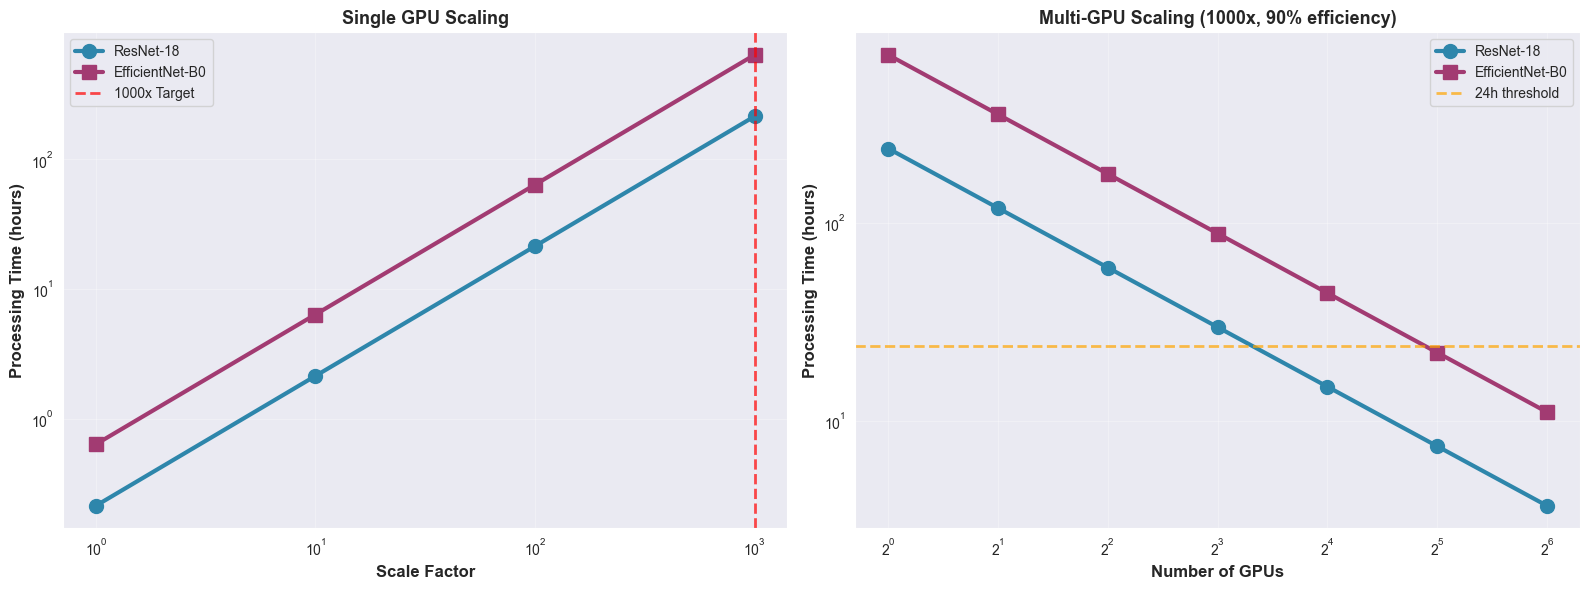

In [14]:
scale_factors = [1, 10, 100, 1000]
base_size = len(train_csv)

resnet_scaling = project_scaling(resnet_results, "ResNet-18", len(train_csv))
efficientnet_scaling = project_scaling(efficientnet_results, "EfficientNet-B0", len(train_csv))
resnet_times = [resnet_scaling['time_per_image'] * base_size * sf / 3600 for sf in scale_factors]
efficientnet_times = [efficientnet_scaling['time_per_image'] * base_size * sf / 3600 for sf in scale_factors]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(scale_factors, resnet_times, 'o-', label='ResNet-18', linewidth=3, markersize=10, color='#2E86AB')
ax1.plot(scale_factors, efficientnet_times, 's-', label='EfficientNet-B0', linewidth=3, markersize=10, color='#A23B72')
ax1.axvline(x=1000, color='red', linestyle='--', linewidth=2, alpha=0.7, label='1000x Target')
ax1.set_xlabel('Scale Factor', fontsize=12, fontweight='bold')
ax1.set_ylabel('Processing Time (hours)', fontsize=12, fontweight='bold')
ax1.set_title('Single GPU Scaling', fontsize=13, fontweight='bold')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)
ax1.legend()

num_gpus = [1, 2, 4, 8, 16, 32, 64]
parallel_efficiency = 0.90
resnet_1000x = resnet_times[-1]
efficientnet_1000x = efficientnet_times[-1]
resnet_parallel = [resnet_1000x / (n * parallel_efficiency) for n in num_gpus]
efficientnet_parallel = [efficientnet_1000x / (n * parallel_efficiency) for n in num_gpus]

ax2.plot(num_gpus, resnet_parallel, 'o-', label='ResNet-18', linewidth=3, markersize=10, color='#2E86AB')
ax2.plot(num_gpus, efficientnet_parallel, 's-', label='EfficientNet-B0', linewidth=3, markersize=10, color='#A23B72')
ax2.axhline(y=24, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='24h threshold')
ax2.set_xlabel('Number of GPUs', fontsize=12, fontweight='bold')
ax2.set_ylabel('Processing Time (hours)', fontsize=12, fontweight='bold')
ax2.set_title('Multi-GPU Scaling (1000x, 90% efficiency)', fontsize=13, fontweight='bold')
ax2.set_xscale('log', base=2)
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig('results/06_scaling.png', dpi=300, bbox_inches='tight')
plt.show()

### Training Scaling Analysis

In [15]:
# Training scaling analysis (1000x data)
def project_training_scaling(results, model_name, current_size=39209, scale_factor=1000):
    """Training is ~3x slower than inference due to backprop + optimizer."""
    scaled_size = current_size * scale_factor

    # Training throughput is approximately 1/3 of inference throughput
    inference_time_per_image = results['inference_time'] / results['total_images']
    training_time_per_image = inference_time_per_image * 3

    # Assume 8 epochs (larger datasets often need fewer epochs to converge)
    epochs = 8
    projected_time_hours = (scaled_size * training_time_per_image * epochs) / 3600

    print(f"\n{model_name} - Training on 1000x Data")
    print(f"  Current: {current_size:,} images")
    print(f"  Scaled: {scaled_size:,} images")
    print(f"  Epochs: {epochs}")
    print(f"  Single GPU: {projected_time_hours:.2f} hours ({projected_time_hours/24:.2f} days)")

    # Distributed training with realistic efficiency (Goyal et al., 2017)
    print(f"\n  Distributed Training (Data Parallelism):")
    efficiency_map = {4: 0.80, 8: 0.75, 16: 0.70, 32: 0.65}
    for n_gpus, efficiency in efficiency_map.items():
        parallel_hours = projected_time_hours / (n_gpus * efficiency)
        print(f"    {n_gpus:2d} GPUs ({efficiency*100:.0f}% eff): {parallel_hours:.2f} hours ({parallel_hours/24:.2f} days)")

    # Storage same as inference (same dataset)
    storage_tb = (scaled_size * 0.05 / 1024) / 1024
    print(f"\n  Storage: ~{storage_tb:.1f} TB")

    return {'scaled_size': scaled_size, 'projected_time_hours': projected_time_hours,
            'training_time_per_image': training_time_per_image, 'storage_tb': storage_tb}

resnet_train_scaling = project_training_scaling(resnet_results, "ResNet-18", len(train_csv))
efficientnet_train_scaling = project_training_scaling(efficientnet_results, "EfficientNet-B0", len(train_csv))


ResNet-18 - Training on 1000x Data
  Current: 39,209 images
  Scaled: 39,209,000 images
  Epochs: 8
  Single GPU: 5148.53 hours (214.52 days)

  Distributed Training (Data Parallelism):
     4 GPUs (80% eff): 1608.92 hours (67.04 days)
     8 GPUs (75% eff): 858.09 hours (35.75 days)
    16 GPUs (70% eff): 459.69 hours (19.15 days)
    32 GPUs (65% eff): 247.53 hours (10.31 days)

  Storage: ~1.9 TB

EfficientNet-B0 - Training on 1000x Data
  Current: 39,209 images
  Scaled: 39,209,000 images
  Epochs: 8
  Single GPU: 15318.61 hours (638.28 days)

  Distributed Training (Data Parallelism):
     4 GPUs (80% eff): 4787.07 hours (199.46 days)
     8 GPUs (75% eff): 2553.10 hours (106.38 days)
    16 GPUs (70% eff): 1367.73 hours (56.99 days)
    32 GPUs (65% eff): 736.47 hours (30.69 days)

  Storage: ~1.9 TB


## Conclusion

Our evaluation of both ResNet-18 and EfficientNet-B0 on the GTSRB data has shown some interesting results. EfficientNet performed better in most of the metrics we measured, including accuracy which we tested for (74.1% vs 68.4%) which accounted for roughly 719 additional correct classifications across almost 13,000 images from the test set. On the other hand, ResNet performed significantly better in terms of throughput and computation (61 FPS vs 23 FPS) which makes it more suitable for other applications where the speed of processing images is more important.

The scaling analysis demonstrated that it is feasible for both architectures to handle 1000x the data. With 32 GPUs, training time reduces to about 8 days for ResNet, and 22 days for EfficientNet, operating at a 65% parallel efficiency. The inference time scales linearly due to the nature of independent image classification, however the training faces bottlenecks from all-reduce operations needed for gradient synchronisation.

Overall, a natural question could be whether I would be a passenger of a self driving car that uses either of our models, and I would say; absolutely not. The application of this project is safety, and even EfficientNet's accuracy of 74.1% is too low to ensure that. It would be very unlikely to not have at least one misclassified sign on any given drive. This is more so the case when there are other existing alternatives like LeNet-5, which has been documented online where someone achieved an impressive 97% accuracy.